## Validation analysis against open/closed cells
---------------
This notebook focuses on the validation analysis, which includes inference of trained model with lablled input data and clustering against the output of model.

-----------
### Recap: Definition of open/closed cells
we ONLY need CLEAR open and closed cells s.t. very simillar to following pictures.  
Other than these figures, we DONOT NEED them (Or, peripheral/boundary patches of these clear ones are nice to save for following analysis)

#### Open cell
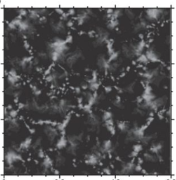
![Open]("./img/open.PNG")

##### Closed cell
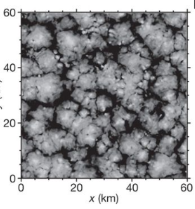
![Closed]("./img/closed.PNG")


---------------
### Prerequisites
Libraries below are necessary to download on you laptop (If disk amount is issue, we can move to Midway cluster-computer where the analysis is much easier if you have already got the access)

1. Tensorflow 1.12.0 for CPU [stackoverflow How to install CPU version of Tnesorflow](https://stackoverflow.com/questions/53614262/how-to-install-cpu-version-of-tensorflow-using-conda)
2. PySpark [pyspark](https://pypi.org/project/pyspark/)

--------------
### Load module

In [2]:
import os
import glob
import sys
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import patches as mpl_patches

# pyspark libs
import pyspark
from pyspark import SparkContext 
from pyspark.mllib.clustering import BisectingKMeans, BisectingKMeansModel

In [3]:
## directory where your put lib_hdfs
libdir='lib_hdfs'

In [4]:
sys.path.insert(1,os.path.join(sys.path[0],libdir)) # this line helps you to use your own functinos in another directory
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array

### Load Model

In [5]:
homedir = libdir
datadir = homedir+"/model/m2_02_global_2000_2018_band28_29_31"
step = 100000 # DONOT change so far

In [6]:
encoder_def = datadir+'/encoder.json'
encoder_weight = datadir+'/encoder-'+str(step)+'.h5'
with open(encoder_def, "r") as f:
    encoder = tf.keras.models.model_from_json(f.read())
encoder.load_weights(encoder_weight)

Instructions for updating:
Colocations handled automatically by placer.


/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/layers/core.py:795: UserWarning: models is not loaded, but a Lambda layer uses it. It may cause errors.
  , UserWarning)


### Load labelled open/closed cell
Tasks
1. Combine your open-notebook contents here

In [7]:
%reload_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as mpl_patches
from pyhdf.SD import SD, SDC
import ipywidgets as widgets

In [8]:
# directory where your put lib_hdfs
# e.g. /home/tkurihana/src/src_share/lib_hdfs
homedir='/Users/rubywerman/desktop/clouds/src_shared/lib_hdfs'

In [9]:
sys.path.insert(1,os.path.join(sys.path[0],homedir)) # this line helps you to use your own functinos in another directory
from alignment_lib import gen_mod02_img_sigle,  gen_mod35_img_single
from alignment_lib import mod02_proc_sds_single
from alignment_lib import _gen_patches
from alignment_lib import const_clouds_array

In [10]:
# enter name of text file containing the dates
closed_file_name = "/Users/rubywerman/desktop/clouds/src_shared/lib_hdfs/chile/closed_cells/chile_closed_cell_dates.txt"
closed_text_file = open(closed_file_name, "r")
closed_dates = closed_text_file.read().split('\n')

# enter name of text file containing the dates
open_file_name = "/Users/rubywerman/desktop/clouds/src_shared/lib_hdfs/chile/open_cells/chile_open_cell_dates.txt"
open_text_file = open(open_file_name, "r")
open_dates = open_text_file.read().split('\n')

In [11]:
#select directory path for given date
def get_data(d):
    return (homedir+'/mod02/open_chile_3/' + d, homedir+'/mod35/open_chile_3/' + d, get_coded_date(d))

In [12]:
#this function takes in a date in "YYYY-MM-DD" format and outputs the date as the year and what number day in the year it is
#example: "2001-01-15" --> 2001015
def get_coded_date(date):
    days_per_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    days_per_month_leap = [31, 29, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    leap_years = [2000, 2004, 2008, 2012]
    year = int(date[0:4])
    month = int(date[5:7])
    day = int(date[8:])
    days = day
    if month != 1:
        calendar = days_per_month
        if year in leap_years:
            calendar = days_per_month_leap
        for m in range(month - 1):
            days += calendar[m]
    return str(year * 1000 + days)

In [13]:
#select directory path to where your open or closed cell data is
def get_closed_coords(selected_date):
    patches = []
    cell_name = "/Users/rubywerman/desktop/clouds/src_shared/lib_hdfs/chile/closed_cells/closed-cell_" + selected_date + ".py"
    f = open(cell_name, "r")
    f.readline()
    line = f.readline()
    while line != '\n':
        coords = line[1:-2]
        coords = coords.split(', ')
        coords = [int(i) for i in coords]
        patches.append(coords)
        line = f.readline()
    return patches

In [14]:
#select directory path to where your open or closed cell data is
def get_open_coords(selected_date):
    patches = []
    cell_name = "/Users/rubywerman/desktop/clouds/src_shared/lib_hdfs/chile/open_cells/open-cell_" + selected_date + ".py"
    f = open(cell_name, "r")
    f.readline()
    line = f.readline()
    while line != '\n':
        coords = line[1:-2]
        coords = coords.split(', ')
        coords = [int(i) for i in coords]
        patches.append(coords)
        line = f.readline()
    return patches

In [343]:
def show_all_closed_patches(dates):
    #function to display patches
    mod02_list = []
    for d in dates:
        mod02_hdfdir, mod35_hdfdir, date = get_data(d)
        # genetate numpy array for mod02, mod35 data
        mod02_img = gen_mod02_img_sigle(hdf_datadir=mod02_hdfdir, date=date)
        for coords in get_closed_coords(d):
            mod02_list.append(mod02_img[coords[0]*128:coords[1]*128, coords[2]*128:coords[3]*128])
    return mod02_list     

In [342]:
def show_all_open_patches(dates):
    #function to display patches
    mod02_list = []
    for d in dates:
        mod02_hdfdir, mod35_hdfdir, date = get_data(d)
        # genetate numpy array for mod02, mod35 data
        mod02_img = gen_mod02_img_sigle(hdf_datadir=mod02_hdfdir, date=date)
        for coords in get_open_coords(d):
            mod02_list.append(mod02_img[coords[0]*128:coords[1]*128, coords[2]*128:coords[3]*128])
    return mod02_list

### Run Analysis
we will use a type of hierarchical clusering called `bisecting-kmeans` [pyspark bisecting-kmeans](https://spark.apache.org/docs/2.2.0/mllib-clustering.html#bisecting-k-means) .   

* In the case...  
If anything trouble happened, you may use another hierarchical clustering called `Agglometative clustering` . How to donwload agglomerative [sklearn aggl](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html)  

`from sklearn.cluster import AgglomerativeClustering`

In [19]:
# make patches
# normalization should False. DO NOT turn on Truth
open_patches = [_gen_patches(x, normalization=False) for x in show_all_open_patches(open_dates)]
closed_patches = [_gen_patches(x, normalization=False) for x in show_all_closed_patches(closed_dates)]

Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31


Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31
Process bands 6
Process bands 7
Process bands 20
Process bands 28
Process bands 29
Process bands 31


/Users/rubywerman/Desktop/clouds/TakGlobus/lib_hdfs/alignment_lib.py:364: RuntimeWarning: Mean of empty slice
  swath_mean = np.nanmean(swath, axis=(0,1))
/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1628: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/Users/rubywerman/Desktop/clouds/TakGlobus/lib_hdfs/alignment_lib.py:370: RuntimeWarning: invalid value encountered in less
  ill_stds = np.where(swath_std < 1.0e-20)[0]


you have to save where/which patches are labelled as open/closed cell.

below you may create a list of patches of both open and closed patches.
you have to save where/which patches are labelled as open/closed cell.

In [727]:
# here make patches list
patches_list = open_patches + closed_patches

In [728]:
patches_list_x = []
for p in patches_list:
    if type(p) is not list:
        patches_list_x.append(p)
patches_list = patches_list_x

In [729]:
print("Number of patches recorded: " + str(len(patches_list)))

Number of patches recorded: 294


###### Inference

In [731]:
encs_list = []
for i in patches_list:
    ix, iy = i.shape[:2]
    encs = encoder.predict(i.reshape(ix * iy, 128,128,6))
    encs_list += [encs.mean(axis=(1,2))]

In [733]:
features = np.concatenate(encs_list, axis=0)
print(features.shape)  # make sure, the shape is [#number of patches, 128]

(5556, 128)


##### Clustering

In [1124]:
def get_clusters_data(label, num_open_features):
    clusters_data = {}
    for i in range(len(label)):
        if i < num_open_features:
            clusters_data[i] = [0, label[i]]
        else:
            clusters_data[i] = [1, label[i]]
    return clusters_data

In [1123]:
#the first 2125 rows in features are open cells 
num_open_features = 2125
#starting at row 2125 in features they are closed cells 
num_closed_featres = 3431

In [1047]:
from sklearn.cluster import AgglomerativeClustering

In [1111]:
num_clusters = 7# N in [2, inf) 
#you can change this number but save the result differently

In [1112]:
#get rid of any data that has inifinity / nan values
cleaned_features = features[~np.isnan(features).any(axis=1)]

In [1113]:
clustering = AgglomerativeClustering(num_clusters)

In [1114]:
#generate clustering data
label = clustering.fit_predict(cleaned_features)

## Visualize clustering accuracy

No handles with labels found to put in legend.


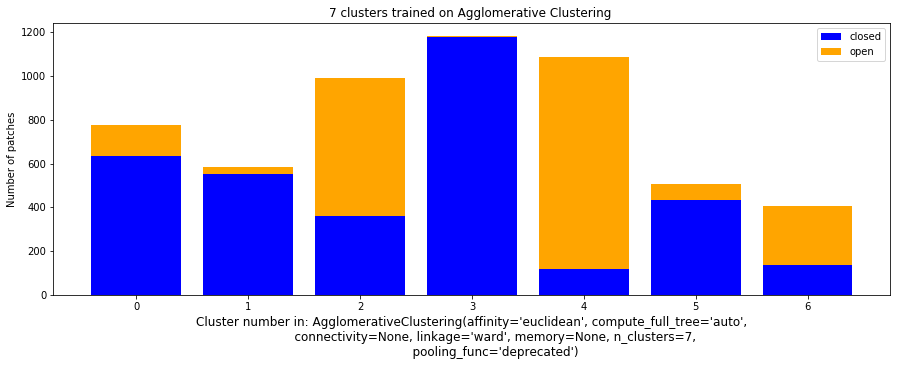

In [1125]:
#make plot by entering num_clusters, label and num_open_features
import itertools

def make_plot(num_clusters, label, num_open_features):
    plt.figure(figsize=(15, 5))
    cell_labels = [str(i) for i in range(num_clusters)]
    clusters_data = get_clusters_data(label, num_open_features)    
    bins = []
    for i in range(num_clusters):
        open_cluster = len([label[x] for x in range(len(label)) if clusters_data[x][0] == 0 and clusters_data[x][1] == i])
        closed_cluster = len([label[x] for x in range(len(label)) if clusters_data[x][0] == 1 and clusters_data[x][1] == i])
        bins.append((closed_cluster, open_cluster))
    width = .8
    bar_list = []
    colors = ['blue', 'orange']
    for i,order in enumerate(bins):
        bottom_counter = 0
        loc_plts = []
        for o,c in zip(order,itertools.cycle(colors)):
            bar = plt.bar(i, o, width, color=c, bottom=bottom_counter)
            loc_plts.append(bar)
            bottom_counter+=o
        bar_list.append(loc_plts)

    #plt.xticks(10, [str(i) for i in range(num_clusters)])
    plt.ylabel("Number of patches")
    plt.xlabel("Cluster number in: "+ str(clustering), fontsize=12)
    plt.legend(loc="upper right")
    plt.legend(('closed','open'))
    plt.title("%d clusters trained on Agglomerative Clustering "%(num_clusters))
    plt.show()
make_plot(num_clusters, label, num_open_features)



Visuallise how open and closed clusteres are differently classified

No handles with labels found to put in legend.


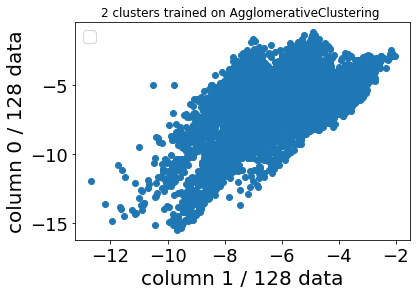

In [1007]:
plt.scatter(cleaned_features[:,0],cleaned_features[:,1], cmap='rainbow')  
plt.xlabel("column 1 / 128 data", fontsize=20)
plt.ylabel("column 0 / 128 data", fontsize=20)
plt.title("%d clusters trained on AgglomerativeClustering "%(num_clusters))
plt.legend(fontsize=16, loc='upper left')
plt.tick_params(labelsize=18)

No handles with labels found to put in legend.


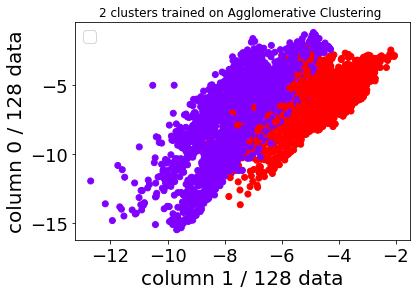

In [440]:
plt.scatter(cleaned_features[:,0],cleaned_features[:,1], c=label, cmap='rainbow')  
plt.xlabel("column 1 / 128 data", fontsize=20)
plt.ylabel("column 0 / 128 data", fontsize=20)
plt.title("%d clusters trained on Agglomerative Clustering "%(num_clusters))
plt.legend(fontsize=16, loc='upper left')
plt.tick_params(labelsize=18)

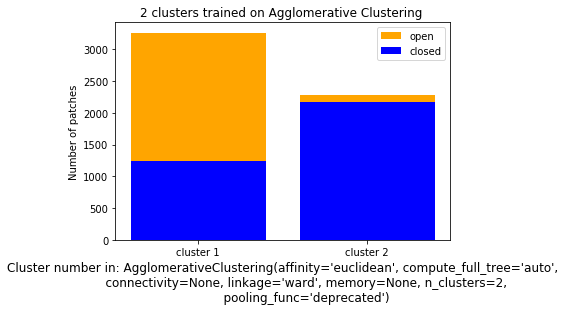

In [1027]:
#0 is open, 1 is closed
cells = ['cluster 1', 'cluster 2']
open_cell = np.array([len(open_in_open), len(closed_in_open)])
closed_cell = np.array([len(open_in_closed), len(closed_in_closed)])

ind = [x for x, _ in enumerate(cells)]

plt.bar(ind, open_cell, width=0.8, label='open', color='orange', bottom=closed_cell)
plt.bar(ind, closed_cell, width=0.8, label='closed', color='blue')

plt.xticks(ind, cells)
plt.ylabel("Number of patches")
plt.xlabel("Cluster number in: "+ str(clustering), fontsize=12)
plt.legend(loc="upper right")
plt.title("%d clusters trained on Agglomerative Clustering "%(num_clusters))
plt.show()

In [ ]:
    indx = [x for x, _ in enumerate(cell_labels)]

    plt.xticks(indx, cell_labels)
    plt.ylabel("Number of patches")
    plt.xlabel("Cluster number in: "+ str(n_clustering), fontsize=12)
    plt.legend(loc="upper right")
    plt.title("%d clusters trained on Agglomerative Clustering "%(clusters))


In [1086]:
open_labels = label[:num_open_features]
closed_labels = label[num_open_features:]
open_in_open = [i for i in open_labels if i == 0]
closed_in_open = [i for i in open_labels if i == 1]
open_in_closed = [i for i in closed_labels if i == 0]
closed_in_closed = [i for i in closed_labels if i == 1]